# 4. PyTorch Custom Datasets

We can use our own data into PyTorch using -> Custom Datasets

Depending on what we are working on, vision, text, audio, recommendataion, you'll want to look into each of the PyTorch domain libraries for existing dta loading functions and suctomizable data loading functions

## **0.** Importing Libraries and setting up device-agnostic code

In [ ]:
import torch
import torchvision
from torch import nn

#Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'



## **1.** Get Datasets

Dataset which will be used is a subset of the Food101 dataset.

Food101 has 101 classes of food, with 1000 images of each (750 train, 250 test)

Our data has 3 classes of food, with 100 images of each (75 train, 25 test).

Why do this?
* Important to start out small, then incease scale
* Speeds up the experimentation

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path/ "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"Directory exists, skipping download")
else:
  print(f"Creating new directory")
  image_path.mkdir(parents=True, exist_ok=True)

Creating new directory


In [ ]:
# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip' , 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading pizza, steak, sushi data...')
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip' , 'r') as zip_ref:
  print('Unzipping pizza, steak and sushi data...')
  zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi data...


## **2.** Data Exploration and preparation

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through the path returning its contents.
  """
  for dirpath, dirnames, filnames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filnames)} images in `{dirpath}`.")

walk_through_dir(image_path)

There are 2 directories and 0 images in `data/pizza_steak_sushi`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/test`.
There are 0 directories and 31 images in `data/pizza_steak_sushi/test/sushi`.
There are 0 directories and 19 images in `data/pizza_steak_sushi/test/steak`.
There are 0 directories and 25 images in `data/pizza_steak_sushi/test/pizza`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/train`.
There are 0 directories and 72 images in `data/pizza_steak_sushi/train/sushi`.
There are 0 directories and 75 images in `data/pizza_steak_sushi/train/steak`.
There are 0 directories and 78 images in `data/pizza_steak_sushi/train/pizza`.


In [ ]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let us write code to:
1. Get all the image paths
2. Pick random image path using random.choice()
3. Get the image class name using `pathling.Path.parent.stem`
4. Open image with PIL
5. We'ss will show and print meta data

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/test/pizza/398345.jpg
Image class: pizza
Image height: 344
image width: 512


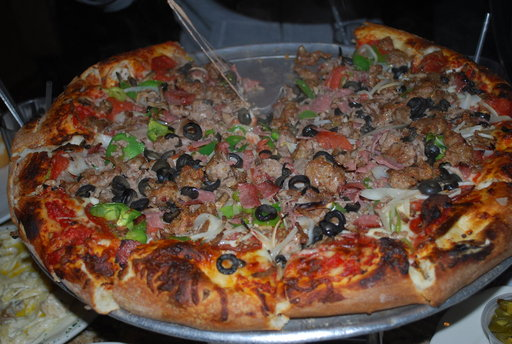

In [ ]:
import random
from PIL import Image

#set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
# first * : test or train
# second * : pizza / sushi / steak
# third * : Any image within the folder

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class [food name] where image is saved
image_class = random_image_path.parent.stem

# 4. Open iamge
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")

img

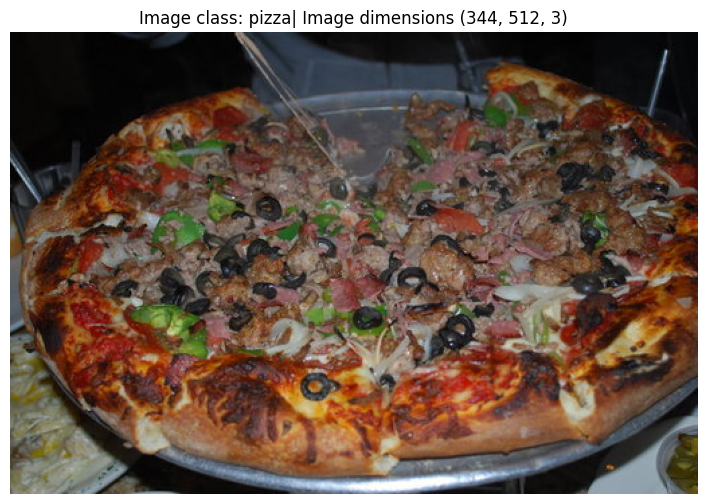

In [ ]:
# Try to Use numpy
import numpy as np
import matplotlib.pyplot as plt

# Turn image into a array
img_as_array = np.asarray(img) # PIL Image to matplotlib image -> need to convert to numpy

# Plot the image
plt.figure(figsize=(12,6))
plt.title(f"Image class: {image_class}| Image dimensions {img_as_array.shape}") # height, weight, colors
plt.axis(False)
plt.imshow(img_as_array)

## **3.** Transforming data

Transform data into tensor format to be useable for PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Change `torch.utils.Datasets` -> `torch.utils.DataLoaders`: From pytorch dataset to python iterables

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms het the images ready to be used with the model

In [ ]:
from typing_extensions import dataclass_transform
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64,64)),
    # We perform this so that we can use pre-build models which have same config. Ex: TinyVGG

    # Flip the images randomly -> (AKA) Data Augmentation, which increases the diversity of the dataset
    transforms.RandomHorizontalFlip(0.5),
    # 50% of the images which get transformed will be flipped horizontally

    # Turn the image into a tensor
    transforms.ToTensor()
])
# nn.Sequential can also be used instead of transforms.Compose to have a sequence of transformations

In [ ]:
data_transform(img).shape, data_transform(img).dtype
# Colors, height, width

(torch.Size([3, 64, 64]), torch.float32)

In [ ]:
def plot_transformed_images(image_paths : list,
                            transform,
                            n=3,
                            seed=None):
  """
  Selects 3 random images when passed in the list of paths
  Print the transformed version vs. the original version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for random_image_path in random_image_paths:
    with Image.open(random_image_path) as f:
      fig , ax = plt.subplots(nrows=1, ncols=2) # fig is the 2 picture spaces togather
      # ax - one space within the figure.
      # Many ax makes up one figure
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # Dimension change
      # As PIL has h,w,c but tensor will have c,h,w
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {random_image_path.parent.stem}", fontsize=16)

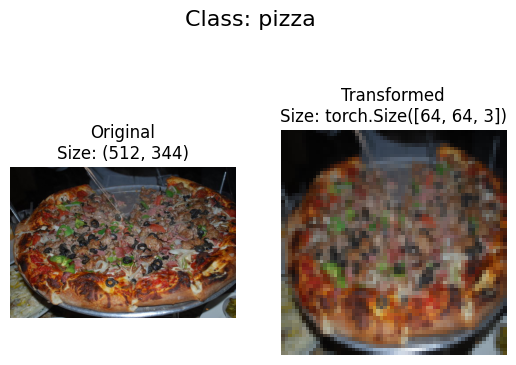

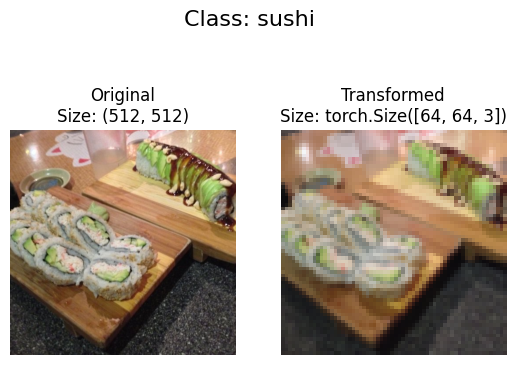

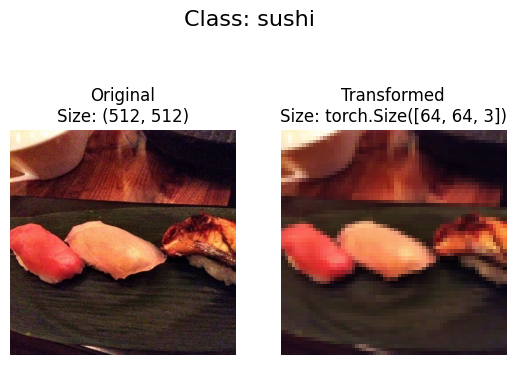

In [ ]:
plot_transformed_images(image_path_list, transform=data_transform, n = 3, seed=42)

## **4.** Option 1: Loading iamge data using `ImageFolder`

Load image classification data using `torchvision.dataset.ImageFolder-`

In [ ]:
# Use ImageFoler to create dataset(s) : which we usually import from torch.datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None # No need for transforming labels as they are in std image classification format
                                  # image classification format: test, train folder -> different classes -> respective images
                                  # So if not using std one, we will not use ImageFolder
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# index on the train_data Dataset and get single image and label
image, label = train_data[0][0], train_data[0][1]

In [ ]:
print(f'Image tensor: {image}')
print(f'Image shape: {image.shape}')
print(f'Image data type: {image.dtype}')
print(f'Image label: {label}')
print(f'label data type: {type(label)}')

Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original Shape: torch.Size([3, 64, 64])| Permuted shape: tensor([[[0.1176, 0.0588, 0.0196],
         [0.1216, 0.0588, 0.0196],
         [0.1255, 0.0588, 0.0157],
         ...,
         [0.0980, 0.0745, 0.0902],
         [0.1020, 0.0706, 0.0902],
         [0.1137, 0.0745, 0.0941]],

        [[0.1294, 0.0627, 0.0196],
         [0.1294, 0.0627, 0.0157],
         [0.1294, 0.0627, 0.0196],
         ...,
         [0.0980, 0.0745, 0.0902],
         [0.0980, 0.0706, 0.0863],
         [0.1059, 0.0745, 0.0902]],

        [[0.1333, 0.0706, 0.0196],
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0157],
         ...,
         [0.0941, 0.0745, 0.0902],
         [0.0980, 0.0745, 0.0902],
         [0.1020, 0.0706, 0.0902]],

        ...,

        [[0.1686, 0.2392, 0.1843],
         [0.1647, 0.2392, 0.1882],
         [0.1686, 0.2510, 0.1961],
         ...,
         [0.1255, 0.1373, 0.1490],
         [0.1098, 0.1333, 0.1333],
         [0.1098, 0.1255, 0.1294]],

        [[0.1686, 0.2314,

Text(0.5, 1.0, 'pizza')

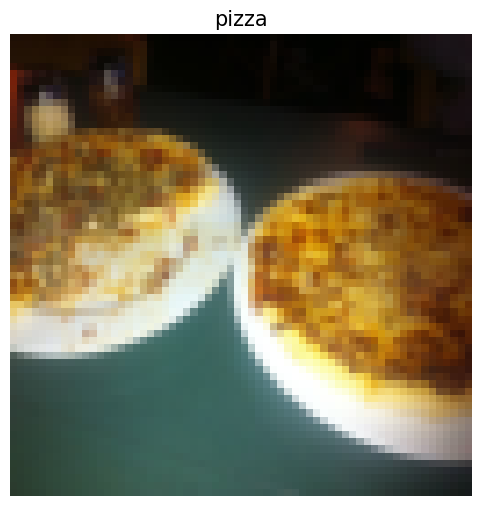

In [ ]:
# Rearrange order of dimersions
img_permute = image.permute(1,2,0)

# Print out different shapes
print(f'Original Shape: {image.shape}| Permuted shape: {img_permute}')
print(f'color, height, width   -->  height, width, color')

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=15)

### 4.1 Turn loaded images into `DataLoader`'s

Turns dataset into python iterable

Can chunck it up into batches to help with hardware constraints

In [ ]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True,
                              )

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=os.cpu_count(), # No. of CPUs used to load the dataset as dataloaders
                              # The higher the better
                              )

img, target = next(iter(train_dataloader))

img, target

(tensor([[[[0.0471, 0.0431, 0.0392,  ..., 0.0196, 0.0196, 0.0157],
           [0.0431, 0.0392, 0.0353,  ..., 0.0235, 0.0196, 0.0157],
           [0.0392, 0.0392, 0.0392,  ..., 0.0196, 0.0196, 0.0196],
           ...,
           [0.1725, 0.1882, 0.1922,  ..., 0.1490, 0.1255, 0.1137],
           [0.1686, 0.1765, 0.1843,  ..., 0.1529, 0.1373, 0.1176],
           [0.1529, 0.1686, 0.1765,  ..., 0.1529, 0.1333, 0.1137]],
 
          [[0.0275, 0.0235, 0.0196,  ..., 0.0157, 0.0157, 0.0118],
           [0.0235, 0.0196, 0.0157,  ..., 0.0157, 0.0157, 0.0118],
           [0.0196, 0.0196, 0.0196,  ..., 0.0157, 0.0157, 0.0157],
           ...,
           [0.0627, 0.0706, 0.0745,  ..., 0.0588, 0.0510, 0.0471],
           [0.0627, 0.0667, 0.0667,  ..., 0.0588, 0.0510, 0.0471],
           [0.0549, 0.0588, 0.0667,  ..., 0.0588, 0.0510, 0.0431]],
 
          [[0.0118, 0.0078, 0.0039,  ..., 0.0078, 0.0039, 0.0000],
           [0.0118, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0000],
           [0.0078, 0.00

In [ ]:
len(train_dataloader), len(test_dataloader)
# The same number as images in train and test data

(225, 75)

In [ ]:
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {target.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


##  **5.** Option 2: Loading Image with a custom `Dataset`

1. Want to be able to load images from file
2. Get class names form Dataset
3. Get classes as dictionary form the Dataset

Pros:
* Create a `Dataset` from almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Usin a custon `Dataset` often results in more code from us -> More errors/ Performance issues


***All custom dataset in PyTorch, often subclass from Datasets in torch***

In [ ]:
import os
import pathlib
import torch

from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (Directory structure might be wrong if this happens)
3. Turn the class names into a dict and list and return them.

In [ ]:
# Setup path directory
target_directory = train_dir
print(f"Target Directory {target_directory}")

# Get the calss names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory.
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise and error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldnt' find any calsses in {directory} .... plese check file structures")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset,, we want to:

1. Subclass `torch.utils.data.Datset`
2. Init our sublass with a target directory (the directory we'd like to get data from) as well as transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this fucntion will open an image
5. Overwirte the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed and index                                              

In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. initialize our custom dataset
  def __init__(self,
               target_directory:str,
               transform=None):

    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(target_directory).glob('*/*.jpg')) # EX: pizza, 2032.jpg
    # Since the starting directory is either test of train, there is only 2 stars

    # Setup transforms
    self.transform = transform

    # Create classes and classes_to_idx
    self.classes, self.class_to_idx = find_classes(target_directory)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path an returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "returns the total number of sampls"
    return len(self.paths)

  # 6. Overwirte ___getitem()__
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X, y)
    return img, class_idx # return untransformed image and label

In [ ]:
# Create a transform
trani_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir,
                                      transform=trani_transforms)

test_data_custom = ImageFolderCustom(target_directory=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fc55874fee0>,
 <__main__.ImageFolderCustom at 0x7fc55874d9c0>)

In [ ]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# Check if both ImageFolders are equal
print(train_data.classes==train_data_custom.classes)
print(test_data.class_to_idx==test_data_custom.class_to_idx)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and other parameters such as class anmes and how many images to visualize.
2. To prevent the display, cap @ 10
3. Set the random sed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None
    ):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"N cannot be larger than 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=10)

  # 5. Setup Plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexs and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # color_channels, height, width -> height, width, color_channels

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title, fontsize=10)

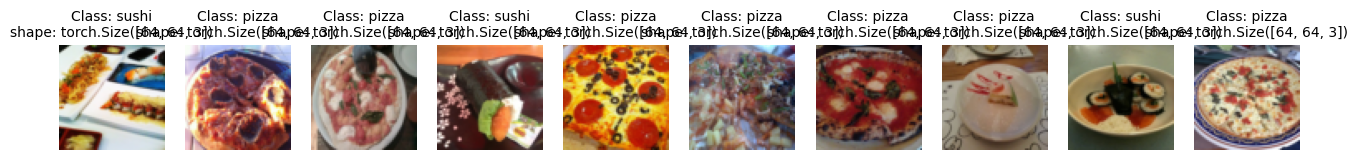

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                     n=10,
                     classes=class_names,
                     seed=42)

N cannot be larger than 10


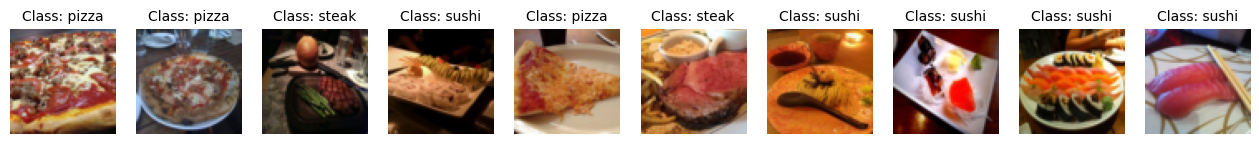

In [ ]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `Dataloader's`

In [ ]:
from torch.utils.data import dataloader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset= train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=0)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    shuffle=False,
                                    num_workers=0,
                                    batch_size=BATCH_SIZE)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fc5564b79d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc5564b7ac0>)

In [ ]:
os.cpu_count()

2

In [ ]:
# Get a sample from custom dataloader
img, targ = next(iter(train_dataloader_custom))
img.shape, targ.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## **6.** Other forms of transforms (data augmentation)

Data Augmentation is the process of artificially adding diversity to training dataset by manipulating the existing data.

In the case fo image data, this may mean applying various image transformations to the training images.

This will lead to better model prediction on unseen data

Most particular type to train models to state of the art levels.


In [ ]:
# We will perform trivial augmetation
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Number signifies how harsh the augmentation happens
    # Higher the number -> more the augmentations. Now each image can be augmented in scale 0 upto scale 31
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

In [ ]:
## Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg')]

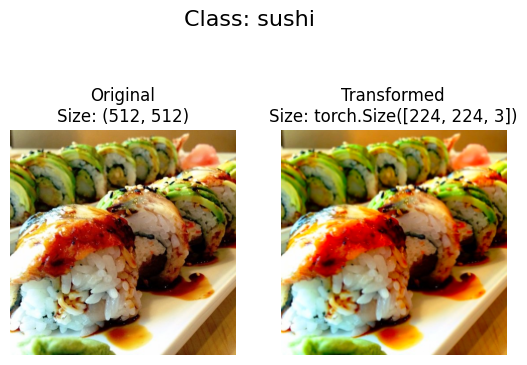

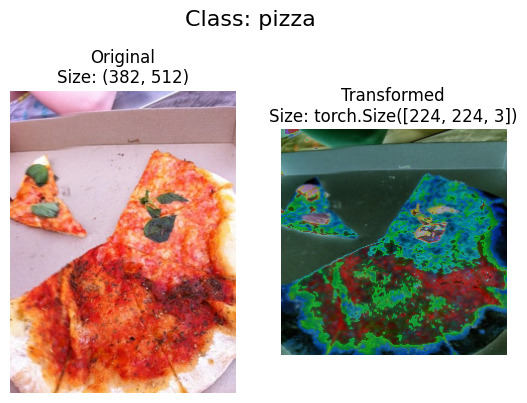

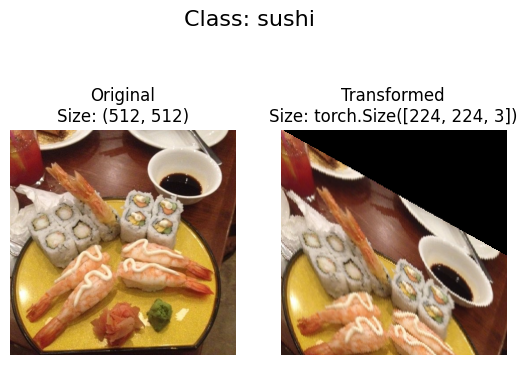

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    seed=None,
    n=3,
)

## **7.** Model 0: Build Tiny VGG architecture without augmenting train data

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
])

In [ ]:
# Using ImageFolder to create a datset

# 1. Load and transform data
from torchvision.datasets import ImageFolder
train_data_simple = ImageFolder(
    root=train_dir,
    transform=simple_transform,
    target_transform=None,
)

test_data_simple = ImageFolder(
    root=test_dir,
    transform=simple_transform,
    target_transform=None,
)

# 2. Turn datasets into dataloaders
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

### 7.2 Build TinyVGG model class

In [ ]:
from torch import nn

class TinyVGG(nn.Module):
  """ Model Architecture copying TinyVGG from CNN Explainer"""
  def __init__(
      self,
      input_shape : int,
      hidden_features : int,
      output_shape : int,
      ):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_features,
                  kernel_size=3,
                  stride=1,
                  padding=0,
                  ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_features,
            out_channels=hidden_features,
            kernel_size=3,
            padding=0,
            stride=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2), # Default stride = kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_features,
                  out_channels=hidden_features,
                  kernel_size=3,
                  stride=1,
                  padding=0,
                  ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_features,
            out_channels=hidden_features,
            kernel_size=3,
            padding=0,
            stride=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2), # Default stride = kernel size
    )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_features * 13 * 13,
            out_features=output_shape,
          ),
    )

  def forward(self, x: torch.Tensor()) -> torch.Tensor:
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier_layer(x)
    return x
    # We can perform operation fusion: make all the operations at once without writing back to memory like the above example which slows down the gpu processing.
    # We can instead return classifier(conv_2(conv_1(x)))

In [ ]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # num of color channels
                  hidden_features=10, # hyper parameter, same as TineVGG
                  output_shape=3, # num of classes
                  )
model_0.to(device)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# get a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape
image ,label = image_batch[0], label_batch[0]

In [ ]:
# Should always pass an whole batch and not a single image
y_logit = model_0(image_batch.to(device))

In [ ]:
y_logit.softmax(1).argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo import if available
!pip install torchinfo
import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # input size is the batch which will be passed into the model

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
# Create train_step()
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device=device):

  #Put the model in train mode
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_logits = model(X)

    # Loss and acc
    y_preds = y_logits.softmax(1).argmax(1)

    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    train_acc += (y_preds == y).sum().item()/ len(y_logits)

    # Optimizer Zero grad
    optimizer.zero_grad()

    # Backward propagation
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Adjust metrics to get avg loss and acc per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [ ]:
# Create a test_step
def test_step(
    model: torch.nn.Module,
    loss: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device=device):

  # Set model to eval
  model.eval()

  test_acc, test_loss = 0, 0

# Put model in inderence mode
  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):

      #set to device
      X, y = X.to(device), y.to(device)

       # Forward pass
      test_logits = model(X)
      test_preds = test_logits.softmax(1).argmax(1)

      # Loss and accuracy
      test_loss += loss(test_logits, y).item()
      test_acc += (test_preds == y).sum().item() / len(test_logits)

  # Get the batch average
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in parameters needed for train and test functions to run
def train(train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim,
          model: torch.nn.Module,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {'train_loss' : [],
             'train_acc' : [],
             'test_acc' : [],
             'test_loss' : []}

  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}")
    # 3. Loop through train and test steps
    train_loss, train_acc =  train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device)
    test_loss, test_acc = test_step(model=model,
                                    loss=loss_fn,
                                    dataloader=test_dataloader,
                                    device=device)

    # 4. Update the dict with newer values
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)

    # 5. Print out the stats for each epoch
    print(f"Train: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}| Test: Loss = {test_loss:.4f}, Accuracy = {test_acc:.4f}\n ---------------")

  # 6. Return the results dict
  return results

### 7.7 Train and evaluate model 0

In [ ]:
len(train_data.classes)

3

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

loss, acc = test_step(model_0, loss_fn, test_dataloader_simple, device)
loss, acc

(1.0976074934005737, 0.2604166666666667)

In [ ]:
# Set random seed
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recretae an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_features=10,
                  output_shape=3)
model_0.to(device)

# Set up loss function and optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(train_dataloader=train_dataloader_simple,
                test_dataloader=test_dataloader_simple,
                model=model_0,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device)

end_time = timer()

print(f"Total training time {end_time - start_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train: Loss = 1.1063, Accuracy = 0.3047| Test: Loss = 1.0983, Accuracy = 0.3011
 ---------------
Epoch: 2
Train: Loss = 1.0998, Accuracy = 0.3281| Test: Loss = 1.0697, Accuracy = 0.5417
 ---------------
Epoch: 3
Train: Loss = 1.0869, Accuracy = 0.4883| Test: Loss = 1.0808, Accuracy = 0.4924
 ---------------
Epoch: 4
Train: Loss = 1.0843, Accuracy = 0.4023| Test: Loss = 1.0608, Accuracy = 0.5833
 ---------------
Epoch: 5
Train: Loss = 1.0662, Accuracy = 0.4102| Test: Loss = 1.0653, Accuracy = 0.5644
 ---------------
Total training time 8.284935571000005 seconds


### 7.8 Plot a loss curve of a model

A **loss curve** is a way of tracking model's progress over time.

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_acc', 'test_loss'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results dictionary
  """
  # Get the loss and acc values of the results dictionary( training and test)
  train_loss = results['train_loss']
  test_loss = results['test_loss']
  test_acc = results['test_acc']
  train_acc = results['train_acc']

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss Function')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label='train_acc')
  plt.plot(epochs, test_acc, label='test_acc')
  plt.title('Accuracy Function')
  plt.xlabel('Epochs')
  plt.legend()

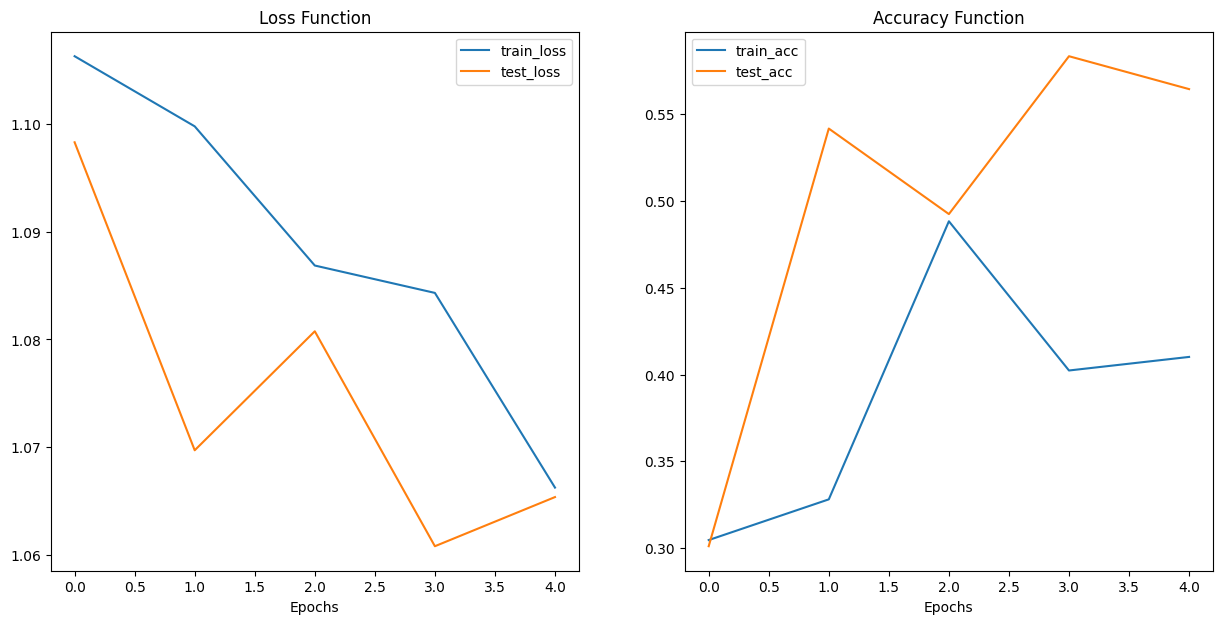

In [ ]:
plot_loss_curves(model_0_results)

## **8.** What should an ideal loss curve look like?

A loss curve is on of the most useful ways to evaluate the models performance

When the loss could be lower for both datasets -> Underfitting

When Train loss < Test loss -> Overfitting

Train loss ~= Train loss and both are low -> JUST RIGHT!

 ## **9.** Model 1: TinyVGG with Data Augmentation

 Now let's try another modelling experiment this time using same model as before + Data augmentation

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc5505a7070>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc55874ea40>)

### 9.3 Construct and train model 1

We will use same architecture + Data Augmentation

In [ ]:

# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_features=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

We need a loss fn and optimizer and use the train function from before

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        device=device,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train: Loss = 1.1049, Accuracy = 0.2500| Test: Loss = 1.1019, Accuracy = 0.2604
 ---------------
Epoch: 2
Train: Loss = 1.0807, Accuracy = 0.4258| Test: Loss = 1.1260, Accuracy = 0.2604
 ---------------
Epoch: 3
Train: Loss = 1.0713, Accuracy = 0.4258| Test: Loss = 1.1593, Accuracy = 0.2604
 ---------------
Epoch: 4
Train: Loss = 1.1259, Accuracy = 0.3047| Test: Loss = 1.1583, Accuracy = 0.2604
 ---------------
Epoch: 5
Train: Loss = 1.0861, Accuracy = 0.4219| Test: Loss = 1.1553, Accuracy = 0.3125
 ---------------
Total training time: 10.510 seconds


### 9.4 get the loss and accuracy plot for model 1

Best way to evaluate model performance

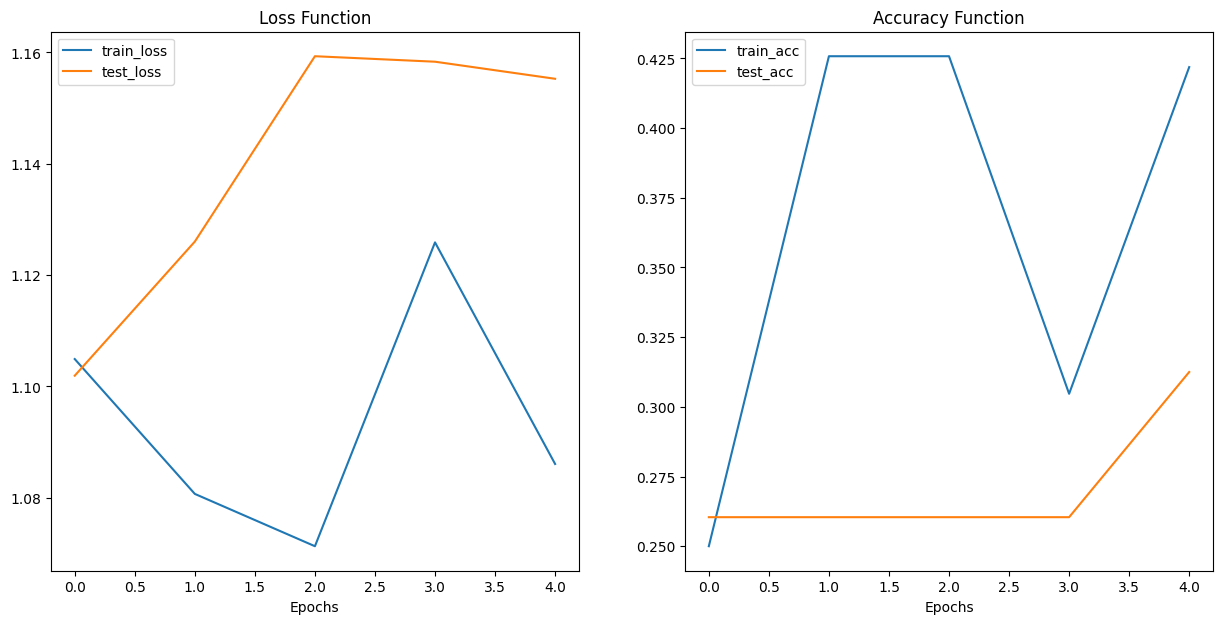

In [ ]:
plot_loss_curves(model_1_results)

## **10.** Compare model results

Evaluate models experiments on their own and on comparison against each other.

Ways to do it:
1. Hard coding (what we do creating functions)
2. PyTorch + Tensorboard
3. Weigts & Biases
4. MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

Text(0.5, 0, 'Epochs')

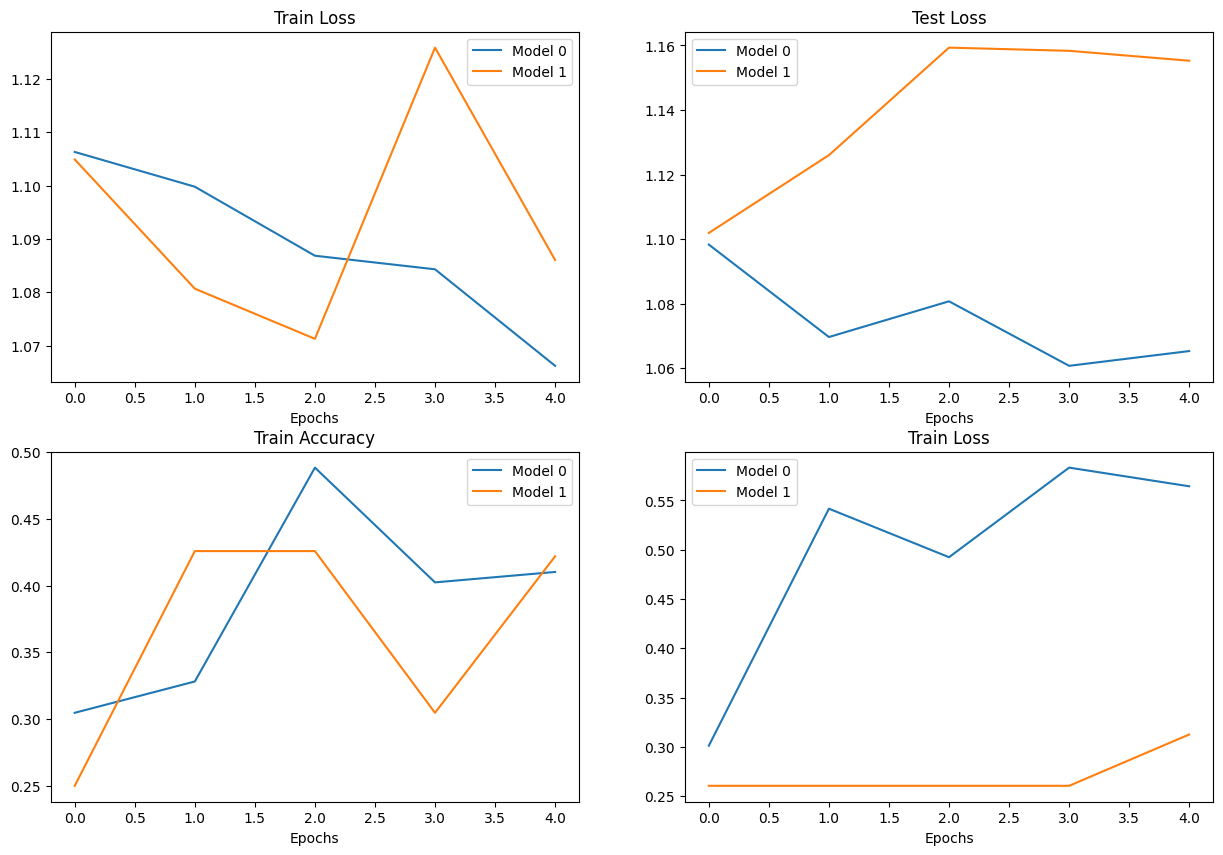

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# get numbher of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title("Train Loss")
plt.legend()
plt.xlabel('Epochs')

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title("Test Loss")
plt.legend()
plt.xlabel('Epochs')

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title("Train Accuracy")
plt.legend()
plt.xlabel('Epochs')

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title("Train Loss")
plt.legend()
plt.xlabel('Epochs')

## **11.** Making a prediction on a custom image

Although we've trained a model on custom data... how do ou make a prediction on a sample/image that's not in either test or train dataset

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg')
    print(f"Downloading {custom_image_path}....")
    f.write(request.content)
else:
  print(f"Skipping Download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure the custom image is in same format as train data

* In tensor form of float Datatype
* Shape 64,64,3
* On the right device

In [ ]:
import torchvision

# read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))

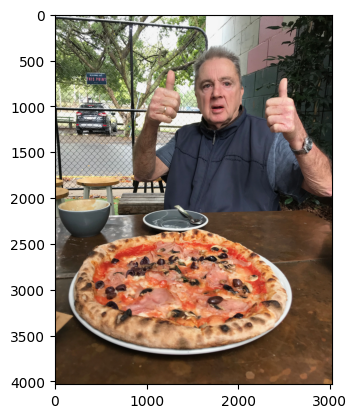

In [ ]:
plt.imshow(custom_image_unit8.permute(1,2,0))

In [ ]:
print(f"Custom image shape: {custom_image_unit8.shape}")
print(f"Custom image datatype: {custom_image_unit8.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])
Custom image datatype: torch.uint8


### 11.2 Making a prediction on a custom image with a trained PyTorch model

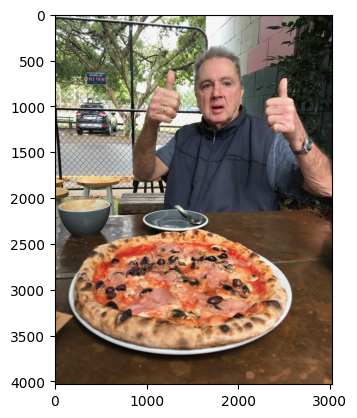

In [ ]:
# Try to make a prediction on an image in unit8 format
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image
# Need to scale the pixel values to be between 1 and 0, so will divide by 255
plt.imshow(custom_image.permute(1, 2, 0))

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


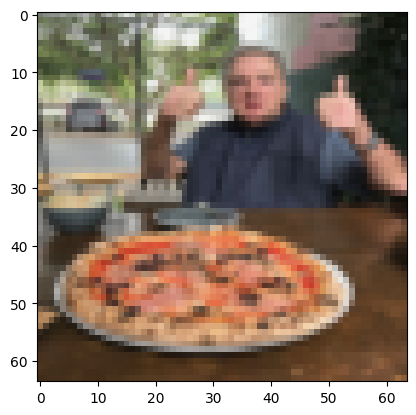

In [ ]:
# Create transform pipeline to rezise image
from torchvision import transforms
custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])

# Transforming image
custom_image_transformed = custom_image_transform(custom_image)
plt.imshow(custom_image_transformed.permute(1,2,0))

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

In [ ]:
# Add a batch size to the single custom image
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# Get a prediction
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [ ]:
custom_image_pred_class = custom_image_pred.softmax(1).argmax(1)

In [ ]:
class_names[custom_image_pred_class]

'pizza'

**NOTE:** To make a prediction on a custom image we had to:
* Load the image and turn into a tensor
* Make sure the image was teh same datatype as teh model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64)
* Make sure the image and model are on same device

### 11.3 Putin custom image predition together: building a function

Ideal outecome:

A fucntion where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transforms= None,
    device=device
):
  """Makes a prediction for a given custom image once it's path is known"""
  # Load in the image and scale it
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255

  # Transform image
  if transforms != None:
    traget_image_transformed = transforms(target_image)

  target = traget_image_transformed.unsqueeze(0)

  # Make sure both are on same device
  target = target.to(device)
  model.to(device)

  # Pass image through the model
  # Add a batch size
  model.eval()
  with torch.inference_mode():
    target_logits = model(target)
    target_preds = target_logits.softmax(1).argmax(1)

  # Display class name
  if class_names != None:
    print(f"Image belongs to: {class_names[target_preds]}")

  # Print image
  plt.imshow(target.squeeze().cpu().permute(1, 2, 0))

Image belongs to: pizza


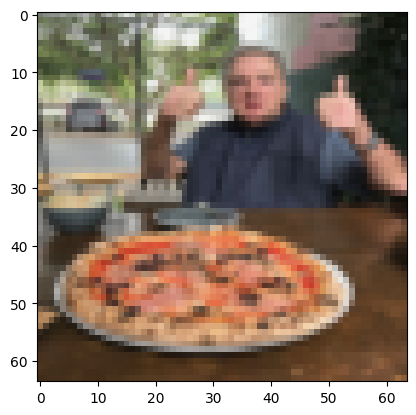

In [ ]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transforms=custom_image_transform,
                    device=device)